In [179]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [180]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})
#print("Dataset : \n")
#print(data.head()) #Stampa per visualizzare il dataset


Total :  13451
Normal :  7500
Malicious :  5951


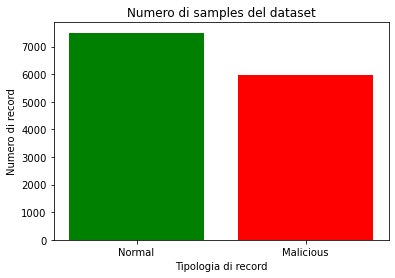

In [181]:
total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [182]:
def preprocessing(data):
    for column in data.columns:
        if data[column].dtype == type(object):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])

In [183]:
data_train = data[data.result == "normal"] #prendo solo i valori "normali" per il train

preprocessing(data_train)
#preprocessing(data)
        
x_train = data_train.drop('result',axis=1) #rimuove la colonna result dal dataframe
#data_val = data.drop('result', axis=1) #per la validation mi servono tutti i record, anche quelli malevoli

#valori per la validation
#data_val = data_val.sample(frac=1).reset_index(drop=True) #randomizza le righe del dataframe resettando gli indici
#percentage = 25
#x_val = data_val.head(int(len(data_val)*(percentage/100))) #prendo il 25% del dataset per la validation

print("x_train dataframe shape: ", x_train.shape)

x_train dataframe shape:  (7500, 21)


<ipython-input-182-14dd7e54de29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


In [184]:
arr_train = x_train.to_numpy() #conversione da dataframe ad array numpy
arr_train = arr_train.reshape(arr_train.shape[0],arr_train.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_train.shape)

#arr_val = x_val.to_numpy()

Training input shape:  (7500, 21, 1)


In [185]:
model = keras.Sequential(
    [
       layers.Input(shape=(arr_train.shape[1], arr_train.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True, kernel_regularizer = regularizers.l2(0.00)),
       layers.LSTM(4, activation='relu', return_sequences=False),
       layers.RepeatVector(arr_train.shape[1]), 
       layers.LSTM(4, activation='relu', return_sequences=True),
       layers.LSTM(16, activation='relu', return_sequences=True),  
       layers.TimeDistributed(layers.Dense(1))    
    ]
)
model.compile( optimizer='adam', loss='mse')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 21, 16)            1152      
_________________________________________________________________
lstm_61 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 21, 4)             0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 21, 4)             144       
_________________________________________________________________
lstm_63 (LSTM)               (None, 21, 16)            1344      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 21, 1)             17        
Total params: 2,993
Trainable params: 2,993
Non-trainable params: 0
___________________________________________________

In [186]:
history = model.fit(
    arr_train,
    arr_train,
    epochs=45,
    batch_size=125,
    validation_split=0.25,
    #validation_data=(x_val, y_val) #non ho però y_val volendo un autoencoder non supervisionato (?)
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/45
45/45 [==============================] - 1s 20ms/step - loss: 5.2387 - val_loss: 4.6325
Epoch 2/45
45/45 [==============================] - 0s 11ms/step - loss: 5.0594 - val_loss: 4.2360
Epoch 3/45
45/45 [==============================] - 1s 12ms/step - loss: 3.1479 - val_loss: 0.9584
Epoch 4/45
45/45 [==============================] - 1s 11ms/step - loss: 1.2531 - val_loss: 0.5853
Epoch 5/45
45/45 [==============================] - 1s 11ms/step - loss: 1.0774 - val_loss: 0.5496
Epoch 6/45
45/45 [==============================] - 1s 12ms/step - loss: 1.5332 - val_loss: 0.5463
Epoch 7/45
45/45 [==============================] - 1s 11ms/step - loss: 1.1147 - val_loss: 0.6099
Epoch 8/45
45/45 [==============================] - 1s 11ms/step - loss: 1.0783 - val_loss: 0.5114
Epoch 9/45
45/45 [==============================] - 1s 11ms/step - loss: 1.0385 - val_loss: 0.4939
Epoch 10/45
45/45 [==============================] - 1s 11ms/step - loss: 1.0235 - val_loss: 0.4818
Epoch 11/

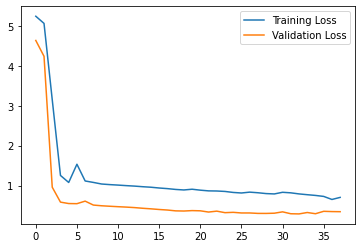

In [187]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

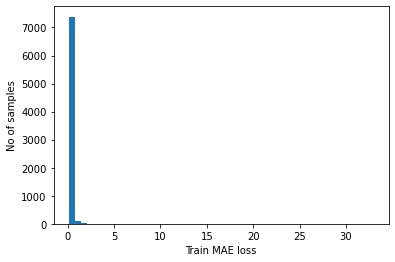

Reconstruction error threshold:  32.952735766462375


In [188]:
x_train_pred = model.predict(arr_train)
train_mae_loss = np.mean(np.abs(x_train_pred - arr_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [189]:
#data_test

preprocessing(data)

x_test = data.drop('result',axis=1) #rimuove la colonna result dal dataframe

x_test = x_test.sample(frac=1).reset_index(drop=True) #randomizza le righe del dataframe resettando gli indici
percentage = 30
x_test_splitted = x_test.head(int(len(data_val)*(percentage/100))) #prendo il 30% del dataset completo per il test

print("x_test_splitted dataframe shape: ", x_test_splitted.shape)

x_test_splitted dataframe shape:  (4035, 21)


In [190]:
arr_test = x_test_splitted.to_numpy() #conversione da dataframe ad array numpy
arr_test = arr_test.reshape(arr_test.shape[0],arr_test.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_test.shape)

Training input shape:  (4035, 21, 1)


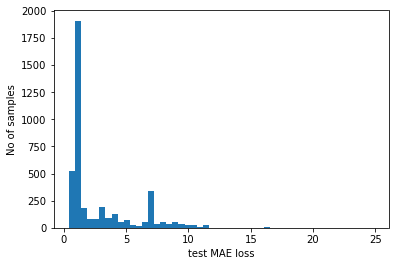

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [191]:
arr_test_pred = model.predict(arr_test)
test_mae_loss = np.mean(np.abs(arr_test_pred - arr_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))                                       